<a href="https://colab.research.google.com/github/isa-ulisboa/Introduction-to-GEE-and-RS/blob/fonda2025/create_shapefile_Ponta_Delgada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas requests zipfile36 fiona


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 57.1 MB/s eta 0:00:00


## Step 1: Download Administrative Boundary Data

Official administrative boundaries for Portugal (including the Azores) are distributed by the Direção-Geral do Território (DGT). These can be found in formats like shapefile or geopackage. For this notebook, we'll fetch a recent geopackage containing municipality boundaries

In [2]:
import requests
import zipfile
import os

# Define URL for the official geopackage (Carta Administrativa Oficial de Portugal - CAOP)
url = "https://geo2.dgterritorio.gov.pt/caop/CAOP_RAA_2024-gpkg.zip"
output_zip = "CAOP_RAA_2024-gpkg.zip"
output_dir = "caop_data"

if not os.path.exists(output_zip):
    print("Downloading official Azores boundary data...")
    r = requests.get(url)
    with open(output_zip, "wb") as f:
        f.write(r.content)

# Extract the downloaded zip file
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

with zipfile.ZipFile(output_zip, "r") as zip_ref:
    zip_ref.extractall(output_dir)

# Identify the geopackage path
gpkgs = [f for f in os.listdir(output_dir) if f.endswith(".gpkg")]
gpkgs


['ArqAcores_GOcidental_CAOP2024.gpkg',
 'ArqAcores_GCentral_GOriental_CAOP2024.gpkg']

## Step 2: Load the Data

In [3]:
import geopandas as gpd
import fiona

# Replace with the actual file name after extraction
gpkgs = [f for f in os.listdir(output_dir) if f.endswith("ArqAcores_GCentral_GOriental_CAOP2024.gpkg")]
gpkg_path = os.path.join(output_dir, gpkgs[0])

# List all layers in the geopackage
layers = fiona.listlayers(gpkg_path)
print(layers)

# Usually, "municipalities" or "concelhos" layer is available
counties_gdf = gpd.read_file(gpkg_path, layer="raa_cen_ori_municipios")
counties_gdf.head()


['raa_cen_ori_areas_administrativas', 'raa_cen_ori_distritos', 'raa_cen_ori_freguesias', 'raa_cen_ori_municipios', 'raa_cen_ori_nuts1', 'raa_cen_ori_nuts2', 'raa_cen_ori_nuts3', 'raa_cen_ori_trocos', 'inf_fonte_troco', 'layer_styles']


,dtmn,municipio,distrito_ilha,nuts3,nuts2,nuts1,area_ha,perimetro_km,n_freguesias,geometry
0,4101,Vila do Porto,Ilha de Santa Maria,Região Autónoma dos Açores,Região Autónoma dos Açores,Região Autónoma dos Açores,9688.74,78,5,"MULTIPOLYGON (((673890.319 4094891.385, 673892..."
1,4201,Lagoa,Ilha de São Miguel,Região Autónoma dos Açores,Região Autónoma dos Açores,Região Autónoma dos Açores,4559.32,45,5,"MULTIPOLYGON (((633620.806 4175581.03, 633613...."
2,4202,Nordeste,Ilha de São Miguel,Região Autónoma dos Açores,Região Autónoma dos Açores,Região Autónoma dos Açores,10146.80,53,9,"MULTIPOLYGON (((663651.393 4182366.539, 663636..."
3,4203,Ponta Delgada,Ilha de São Miguel,Região Autónoma dos Açores,Região Autónoma dos Açores,Região Autónoma dos Açores,23298.65,102,24,"MULTIPOLYGON (((614820.753 4177345.715, 614814..."
4,4204,Povoação,Ilha de São Miguel,Região Autónoma dos Açores,Região Autónoma dos Açores,Região Autónoma dos Açores,10640.77,64,6,"MULTIPOLYGON (((646667.424 4176711.032, 646663..."


## Step 3: Filter for Ponta Delgada county

In [8]:
# View available columns
print(counties_gdf.columns)

# Filter for Ponta Delgada county and simplify geometry (to reduce file size)
saomiguel_counties = counties_gdf[counties_gdf["municipio"] == "Ponta Delgada"]

saomiguel_counties["geometry"]=saomiguel_counties["geometry"].simplify(tolerance=200, preserve_topology=True)

# Optionally verify unique county names
print(saomiguel_counties["municipio"].unique())


Index(['dtmn', 'municipio', 'distrito_ilha', 'nuts3', 'nuts2', 'nuts1',
       'area_ha', 'perimetro_km', 'n_freguesias', 'geometry'],
      dtype='object')
['Ponta Delgada']


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Step 4: Reproject to lat/lon export to shapefile


In [9]:
# Convert GeoDataFrame to WGS84 (latitude/longitude, EPSG:4326)
saomiguel_counties_latlong = saomiguel_counties.to_crs(epsg=4326)
# Export to shapefile
saomiguel_counties_latlong.to_file("saomiguel_counties_latlong.shp")
print(f"Shapefile created: {saomiguel_counties_latlong}")

Shapefile created:    dtmn      municipio       distrito_ilha                       nuts3  \
3  4203  Ponta Delgada  Ilha de São Miguel  Região Autónoma dos Açores   

                        nuts2                       nuts1   area_ha  \
3  Região Autónoma dos Açores  Região Autónoma dos Açores  23298.65   

   perimetro_km  n_freguesias  \
3           102            24   

                                            geometry  
3  POLYGON ((-25.68591 37.73267, -25.70792 37.740...  


/tmp/ipython-input-9-3980944701.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  saomiguel_counties_latlong.to_file("saomiguel_counties_latlong.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'distrito_ilha' to 'distrito_i'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'perimetro_km' to 'perimetro_'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'n_freguesias' to 'n_freguesi'
  ogr_write(


## Step 5: Visualize the Counties (Optional)

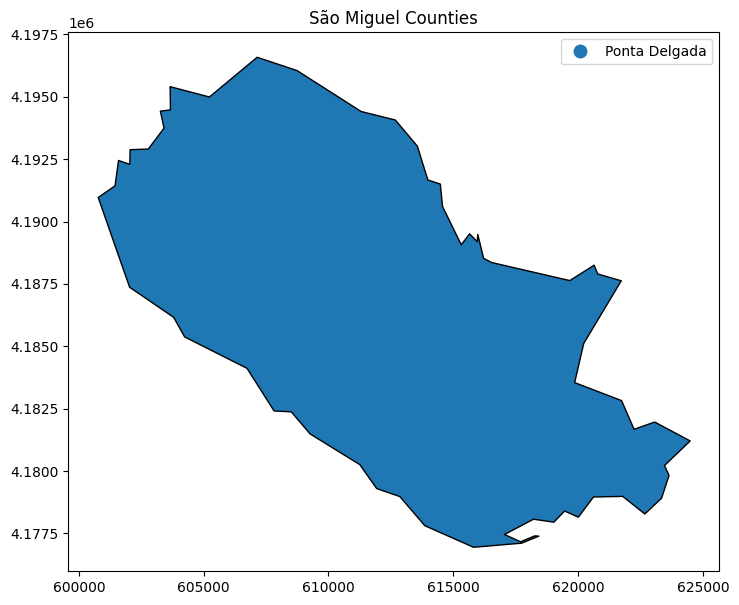

In [10]:
import matplotlib.pyplot as plt

saomiguel_counties.plot(column="municipio", legend=True, edgecolor="black", figsize=(10,7))
plt.title("São Miguel Counties")
plt.show()

## Zip all shapefile files into a single file (to be uploaded to GEE)

In [11]:
import zipfile
import os
from google.colab import files

# List of files to include in the zip archive
files_to_zip = [f for f in os.listdir() if f.startswith("saomiguel_counties_latlong.")]

# Name of the zip archive
zip_filename = "saomiguel_counties_latlong.zip"

# Create the zip archive
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in files_to_zip:
        zipf.write(file)

# Provide a link to download the zip archive
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>